In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from matplotlib import pylab as plt
import h5py
import os
import sys

%matplotlib inline

## 文件路径

In [2]:
TRAIN_CSV = './data/train.csv'
TEST_CSV = './data/test.csv'
MODEL_SAVE = './model_save/model.ckpt'
TRAIN_FEATURE_SAVE = './features_save/total_features.h5'
TEST_FEATURE_SAVE = './features_save/test_features.h5'
PREDICT_CSV_DIR = './predicts_save/'

if not os.path.exists('./model_save/'):
    os.mkdir('./model_save/')
    
if not os.path.exists('./features_save/'):
    os.mkdir('./features_save/')
    
if not os.path.exists('./predicts_save/'):
    os.mkdir('./predicts_save/')

## 数据准备

### 读取数据

In [3]:
total_df = pd.read_csv(TRAIN_CSV)
total_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
final_df = pd.read_csv(TEST_CSV)
final_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
total_X = total_df.iloc[:, 1:].values.reshape(-1, 28, 28, 1)
total_Y = total_df.iloc[:, 0].values.reshape(-1, 1)
final_X = final_df.iloc[:, :].values.reshape(-1, 28, 28, 1)

print('total_X:', total_X.shape)
print('total_Y:', total_Y.shape)
print('final_X:', final_X.shape)

total_X: (42000, 28, 28, 1)
total_Y: (42000, 1)
final_X: (28000, 28, 28, 1)


In [6]:
print('需要预测的数字:', set(np.squeeze(total_Y).tolist()))

需要预测的数字: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


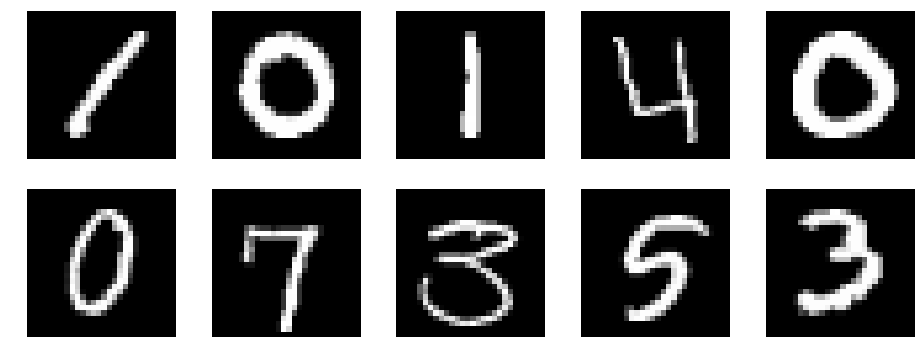

In [7]:
plt.figure(figsize=(16, 6))
plt.rcParams['image.cmap'] = 'gray'
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(total_X[i, :, :, 0])
    plt.axis('off')

### 随机化数据

In [8]:
random_indexes = np.random.permutation(total_X.shape[0])
total_shuffle_X = total_X[random_indexes]
total_shuffle_Y = total_Y[random_indexes]

## 用imagenet预训练的resnet提取所有图片特征，保存到文件

### 特征保存类

In [9]:
class Features_saver:
    def __init__(self, file_path, total_size, feature_size):
        if os.path.exists(file_path):
            os.remove(file_path)
        
        self._h5f = h5py.File(file_path, mode='a')
        self._dataset = self._h5f.create_dataset("features", (total_size, feature_size),
                                                 maxshape=(None, feature_size),
                                                 dtype='float32')
        self._last_point = 0
        
    def __del__(self):
        if self._h5f != None:
            self._h5f.close()
            self._h5f = None
            
    def save_features(self, features):
        self._dataset[self._last_point: self._last_point + features.shape[0]] = features
        self._last_point += features.shape[0]
        
    def save_labels(self, labels):
        self._h5f['labels'] = labels
        
    def close(self):
        if self._h5f is not None:
            self._h5f.close()
            self._h5f = None

### 图片输入管道

In [10]:
def image_process_map(image):
    rgb_image = tf.concat([image, image, image], axis=-1)
    resize_image = tf.image.resize_images(rgb_image, size=(224, 224))
    pre_image = keras.applications.resnet50.preprocess_input(resize_image, mode='tf')
    
    return pre_image;

In [11]:
def gen_images(images, batch_size):
    images_set = tf.data.Dataset.from_tensor_slices(images)
    images_set = images_set.batch(batch_size)
    images_set = images_set.repeat(1)
    images_set = images_set.map(image_process_map, 8)
    images_gen = images_set.make_one_shot_iterator()
    next_images = images_gen.get_next()
    
    return next_images

### 特征提取函数

In [12]:
def build_placeholder():
    inputs = tf.placeholder(shape=(None, 224, 224, 3), dtype=tf.float32, name='inputs')
    
    return inputs

In [13]:
def build_pretrain_resnet(input):
    resnet = keras.applications.resnet50.ResNet50(include_top=False, input_tensor=input, pooling='avg')
    
    return resnet.output

In [14]:
def features_extract(file_path, images, labels=None, batch_size=8):  
    tf.reset_default_graph()
    
    inputs_pl = build_placeholder()
    pretrain_output_op = build_pretrain_resnet(inputs_pl)
    
    with tf.device('/cpu:0'):
        images_gen = gen_images(images, batch_size)
        
    feature_saver = Features_saver(file_path, images.shape[0], 2048)
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    step = 0
    while True:
        try:
            input_images = sess.run(images_gen)
            batch_features = sess.run(pretrain_output_op, feed_dict={inputs_pl: input_images})
            
            feature_saver.save_features(batch_features)
            
            sys.stdout.write('\r%{:.2f}    '.format(100 * step * batch_size / images.shape[0]))
            sys.stdout.flush()
            step += 1
        except tf.errors.OutOfRangeError:
            sys.stdout.write('\r%100    ')
            sys.stdout.flush()
            print('')
            print('Feature extraction complete')
            break
    
    if isinstance(labels, np.ndarray):
        feature_saver.save_labels(labels)
        
    feature_saver.close()
    sess.close()

In [15]:
features_extract(TRAIN_FEATURE_SAVE, total_shuffle_X[:20], total_shuffle_Y[:20])

%100      
Feature extraction complete


In [16]:
# features_extract(TEST_FEATURE_SAVE, final_X[:10])

## 直接用保存的特性训练一个很小的网络

### 划分数据集

In [17]:
h5f = h5py.File(TRAIN_FEATURE_SAVE, mode='r')
total_X_dataset = h5f['features']
total_Y_dataset = h5f['labels']

total_X_dataset.shape
total_Y_dataset.shape

(20, 1)

### 特征、标签生成器

In [18]:
class Features_labels_gen:
    def __init__(self, X_dataset, Y_dataset=None, epochs=1, batch_size=2, shuffle=True):
        self._X_dataset = X_dataset
        self._Y_dataset = Y_dataset
        
        self.total_size = X_dataset.shape[0]
        self.total_steps = self.total_size // batch_size
        if self.total_size % batch_size != 0:
            self.total_steps += 1

        dataset = tf.data.Dataset.from_tensor_slices(np.arange(self.total_size))
        dataset = dataset.repeat(epochs).batch(batch_size)
        if shuffle:
            dataset = dataset.shuffle(buffer_size=self.total_size // batch_size + 10)
        
        self._next_indexes = dataset.make_one_shot_iterator().get_next()
        
    def get_featres_labels(self, sess):
        indexes = list(sess.run(self._next_indexes))

        if self._Y_dataset is None:
            return self._X_dataset[indexes]
        else:
            return self._X_dataset[indexes], self._Y_dataset[indexes]       

In [19]:
gen = Features_labels_gen(total_X_dataset, total_Y_dataset, epochs=2)
with tf.Session() as sess:
    try:
        while True:
            X, Y = gen.get_featres_labels(sess)
    except:
        pass
    

### 微调的小网络

In [20]:
def build_small_net(input, keep_prob=1, shapes=(10,)):
    with tf.name_scope('small_net'):
        layer_output = input
        for index, shape in enumerate(shapes):
            liner_output = tf.layers.dense(layer_output,
                                           shape, 
                                           activation=None,
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
            
            if index == len(shapes) - 1:
                layer_output = tf.nn.softmax(liner_output)
            else:
                layer_output = tf.nn.relu(liner_output)
                if keep_prob != 1:
                    layer_output = tf.nn.dropout(layer_output, keep_prob)
                
    logits = liner_output
    output = layer_output
    
    return logits, output

In [21]:
def build_fineture_input():
    inputs = tf.placeholder(shape=(None, 2048), dtype=tf.float32, name='inputs')
    labels = tf.placeholder(shape=(None, 1), dtype=tf.int32, name='labels') 
    
    return inputs, labels

In [22]:
def build_cost(logits, labels):
    onehot_labels = tf.one_hot(labels, depth=10, axis=-1)
    
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=onehot_labels, logits=logits))

In [23]:
def build_accuracy(outputs, labels):
    predicts = tf.argmax(outputs, axis=-1, output_type=tf.int32)
    is_rights = tf.equal(predicts, tf.reshape(labels, (-1,)))
    accuracy = tf.reduce_mean(tf.cast(is_rights, tf.float32))
    
    return accuracy

In [24]:
def plot(steps, costs, accuracies):
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(list(range(steps)), costs)
    plt.xlabel('step')
    plt.ylabel('cost')
    
    plt.subplot(1, 2, 2)
    plt.plot(list(range(steps)), accuracies)
    plt.xlabel('step')
    plt.ylabel('accuracy')

### 微调

In [44]:
def fineturn(X_train, Y_train, X_dev, Y_dev, lr=0.01, batch_size=2, keep_prob=1, epochs=1, 
             fineture_net_shape=(10,), print_steps=10, plot_steps=5, resume=True):
    tf.reset_default_graph()
    
    inputs_pl, labels_pl = build_fineture_input()
    logits_op, output_op = build_small_net(inputs_pl, keep_prob, fineture_net_shape)
    
    cost_op = build_cost(logits_op, labels_pl)
    accuracy_op = build_accuracy(output_op, labels_pl)
    optimizer_op = tf.train.AdamOptimizer(lr).minimize(cost_op)
    
    train_gen = Features_labels_gen(X_train, Y_train, epochs, batch_size)
    evaluate_train_gen = Features_labels_gen(X_train, Y_train, epochs, batch_size)
    evaluate_dev_gen = Features_labels_gen(X_dev, Y_dev, 1, batch_size)
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    saver = tf.train.Saver()
    if resume:
        saver.restore(sess, MODEL_SAVE)
    
    costs = []
    step_accuracies = []
    
    try:
        step = 0
        while True:
            train_X, train_Y = train_gen.get_featres_labels(sess)
        
            _, cost, step_accuracy = sess.run((optimizer_op, cost_op, accuracy_op),
                                         feed_dict={inputs_pl: train_X, labels_pl: train_Y})
            
            if step % print_steps == 0:
                print('step:{0}--cost:{1:.4f}--step_accuracy:{2:.4f}'.format(step, cost, step_accuracy))
                
            if step % plot_steps == 0:
                costs.append(cost)
                step_accuracies.append(step_accuracy)
            
            step += 1
    except tf.errors.OutOfRangeError:
        pass
    
    train_accuracies = []
    try:
        while True:
            train_X, train_Y = evaluate_train_gen.get_featres_labels(sess)
            accuracy = sess.run(accuracy_op, feed_dict={inputs_pl: train_X, labels_pl: train_Y})
            train_accuracies.append(accuracy)
    except tf.errors.OutOfRangeError:
        pass
    
    evaluate_train_accuracy = np.mean(train_accuracies)
            
    
    dev_accuracies = []
    try:
        while True:
            dev_X, dev_Y = evaluate_dev_gen.get_featres_labels(sess)
            accuracy = sess.run(accuracy_op, feed_dict={inputs_pl: dev_X, labels_pl: dev_Y})
            dev_accuracies.append(accuracy)
    except tf.errors.OutOfRangeError:
        pass
    
    evaluate_dev_accuracy = np.mean(dev_accuracies)
    
    plot(step, costs, train_accuracies)
    
    print('train set accuracy:{0:.4f} \ndev set accuracy:{1:.4f}'.format(evaluate_train_accuracy, evaluate_dev_accuracy))
    
    saver.save(sess, MODEL_SAVE)
    
    sess.close()

step:0--cost:2.3133--step_accuracy:0.0000
step:5--cost:2.2300--step_accuracy:0.0000
step:10--cost:1.8332--step_accuracy:0.5000
step:15--cost:2.2807--step_accuracy:0.5000
train set accuracy:0.3500 
dev set accuracy:0.3500


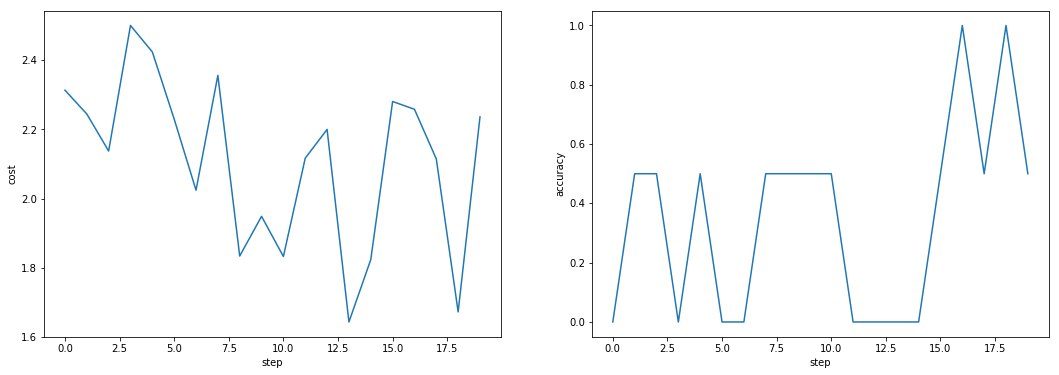

In [45]:
fineturn(total_X_dataset, total_Y_dataset, total_X_dataset, total_Y_dataset,
         lr=0.001, epochs=2, print_steps=5, plot_steps=1, resume=False)

## 预测

In [29]:
def predict(X_dataset, batch_size=64, fineture_net_shape=(10,)):
    tf.reset_default_graph()
    
    inputs_pl, _ = build_fineture_input()
    _, output_op = build_small_net(inputs_pl, 1, fineture_net_shape)
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    saver = tf.train.Saver()
    saver.restore(sess, MODEL_SAVE)

    data_gen = Features_labels_gen(X_dataset, batch_size=batch_size, epochs=1, shuffle=False)
    
    outputs = []
    try:
        while True:
            X = data_gen.get_featres_labels(sess)
            output = sess.run(output_op, feed_dict={inputs_pl: X})
            outputs.append(output)
    except tf.errors.OutOfRangeError:
        pass
    
    predicts = np.concatenate(outputs, axis=0)
    
    return predicts

In [31]:
result = predict(total_X_dataset[:5])
result.shape

INFO:tensorflow:Restoring parameters from ./model_save/model.ckpt


(5, 10)

### 预测结果保存的csv文件

In [32]:
def save_predicts_to_csv(predicts, save_path):
    predicts_arr = np.argmax(predicts, axis=-1)

    df = pd.DataFrame({
        'ImageId': np.arange(1, predicts.shape[0] + 1),
        'Label': predicts_arr,
    })
    
    df.to_csv(save_path, index=False)
    
    return df

In [33]:
df = save_predicts_to_csv(result, PREDICT_CSV_DIR + 'test.csv')
df.head()

,ImageId,Label
0,1,8
1,2,8
2,3,8
3,4,8
4,5,8
